In [1]:
#import all needed packages up front
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

It is very important for companies to understand why and when they will lose employees. This view of attrition can aid them in retaining top talent while also better planning for loss.

Here we have a sample dataset where key features of employyes within a company have been kept and a value for whether that employee left (Yes or No) was provided at a snapshot in time.

Our goal here will be to clean the data, select and tune a feaure set, then create and compare a few models which could assist the company in question address the attrition problem.

**Credit goes to Prashant Patel (https://www.kaggle.com/patelprashant) from where the dataset has been collected**

In [2]:
#read in the dataset
df=pd.read_csv("https://www.dropbox.com/scl/fi/zkaa4dkvip5tkuhdtrrru/employee_attrition.csv?rlkey=urstk5jdsezbzj1da69bvjgf1&st=czxxh2kz&dl=1")

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,50.0,No,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,36.0,No,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,21.0,Yes,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,50.0,No,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,52.0,No,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


In [3]:
#adjust the target variable to be 1 or 0
df["Attrition"]=df["Attrition"].apply(lambda x: 1 if x=="Yes" else 0)

One quick view of what our dataframe looks like.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       893 non-null    float64
 1   Attrition                 1029 non-null   int64  
 2   BusinessTravel            1024 non-null   object 
 3   DailyRate                 1002 non-null   float64
 4   Department                1029 non-null   object 
 5   DistanceFromHome          934 non-null    float64
 6   Education                 1029 non-null   int64  
 7   EducationField            1029 non-null   object 
 8   EmployeeCount             1029 non-null   int64  
 9   EmployeeNumber            1029 non-null   int64  
 10  EnvironmentSatisfaction   1029 non-null   int64  
 11  Gender                    1029 non-null   object 
 12  HourlyRate                1029 non-null   int64  
 13  JobInvolvement            1029 non-null   int64  
 14  JobLevel

We want to take a look at the object columns as these will need to be converted so that they are represented numerically.

In [5]:
for col in df.select_dtypes(include='object').columns:
  print(df[col].value_counts())

BusinessTravel
Travel_Rarely        723
Travel_Frequently    199
Non-Travel           102
Name: count, dtype: int64
Department
Research & Development    676
Sales                     311
Human Resources            42
Name: count, dtype: int64
EducationField
Life Sciences       426
Medical             328
Marketing           110
Technical Degree     82
Other                66
Human Resources      17
Name: count, dtype: int64
Gender
Male      617
Female    412
Name: count, dtype: int64
JobRole
Sales Executive              217
Research Scientist           214
Laboratory Technician        179
Manufacturing Director        95
Healthcare Representative     89
Manager                       73
Sales Representative          66
Research Director             62
Human Resources               34
Name: count, dtype: int64
MaritalStatus
Married     474
Single      320
Divorced    230
Name: count, dtype: int64
Over18
Y    1029
Name: count, dtype: int64
OverTime
No     731
Yes    298
Name: count, dtype

We are going to drop some columns which are missing a large number values, have no variablilty, and/or which clearly have collinearity. For the remaining object columns, we will use get_dummies for those, while ensuring we drop one from each set.

In [6]:
#use get_dummies to convert object columns to numeric features
df=pd.get_dummies(df, columns=['Gender',"OverTime","BusinessTravel","Department","EducationField","JobRole","MaritalStatus"], drop_first=True, dtype=int)
#drop columns that will not be useful, and may be harmful, to our model
df.drop(columns=["Over18","DistanceFromHome","EmployeeCount","EmployeeNumber","DailyRate","HourlyRate"],inplace=True)

From our iniital view of the data, we saw that Age was missing a large number of values. However, where attrition is concerned, it is reasonable to assume that Age could be a significant feature. Therefore, we will create a very simple linear regression model to fill in the missing Age values. We will select features for that very simple model based on correlations to the Age field.

In [7]:
#lool at all correlations versus the Age field
correlation_matrix = df.corr()
age_correlations = correlation_matrix['Age']
print(age_correlations)

Age                                  1.000000
Attrition                           -0.175555
Education                            0.226646
EnvironmentSatisfaction             -0.024051
JobInvolvement                       0.024176
JobLevel                             0.506348
JobSatisfaction                      0.007670
MonthlyIncome                        0.492360
MonthlyRate                          0.018697
NumCompaniesWorked                   0.298354
PercentSalaryHike                    0.011593
PerformanceRating                    0.007457
RelationshipSatisfaction             0.062533
StandardHours                             NaN
StockOptionLevel                     0.023282
TotalWorkingYears                    0.676650
TrainingTimesLastYear               -0.026077
WorkLifeBalance                     -0.042949
YearsAtCompany                       0.291798
YearsInCurrentRole                   0.218028
YearsSinceLastPromotion              0.178679
YearsWithCurrManager              

In [8]:
#create subsets of rows with and without Age value
hasAge=df[df['Age'].notna()]
missingAge=df[df['Age'].isna()]

#based on the correlation matrix, define features for our liner regression model
features=['TotalWorkingYears','JobLevel','MonthlyIncome']

#fit the model
reg=LinearRegression()
reg.fit(hasAge[features],hasAge['Age'])

#predict and assign missing Age values
df.loc[df['Age'].isna(),'Age']=reg.predict(missingAge[features])

To further eliminate non-useful features, we will programatically drop any which have no variance.

In [9]:
zero_variance=df.columns[df.var()== 0]
df.drop(columns=zero_variance,inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1029 non-null   float64
 1   Attrition                          1029 non-null   int64  
 2   Education                          1029 non-null   int64  
 3   EnvironmentSatisfaction            1029 non-null   int64  
 4   JobInvolvement                     1029 non-null   int64  
 5   JobLevel                           1029 non-null   int64  
 6   JobSatisfaction                    1029 non-null   int64  
 7   MonthlyIncome                      1029 non-null   int64  
 8   MonthlyRate                        1029 non-null   int64  
 9   NumCompaniesWorked                 1029 non-null   int64  
 10  PercentSalaryHike                  1029 non-null   int64  
 11  PerformanceRating                  1029 non-null   int64

We now have a complete dataset, which is purely numeric, and where we have a moderate set of features where obvious collinearity and lack of variance have been eliminated.

We will next train a logistic regression model and use the coefficients to see if we can further eliminate features.

In [11]:
x=df.loc[:, df.columns != 'Attrition'] #feature set
y=df["Attrition"] #target variable

#split the data s.t. we have 20% for testing and 80% for training
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=2)

#train a lr using liblinear since it is generally good for small training sets
lr = LogisticRegression(solver='liblinear', random_state=2)
lr.fit(X_train, y_train)

print('# of iterations %s' % lr.n_iter_[0])

test_score = lr.score(X_test, y_test)
train_score = lr.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

# of iterations 29
Score on training data:  0.8780804150453956
Score on test data:  0.8643410852713178


Now that the model is trained, we can inspect the coefficients.

In [12]:
coefficients = lr.coef_
feature_names = X_train.columns
coefficients_df = pd.DataFrame(coefficients, columns=feature_names)
pd.set_option('display.max_columns', None)
coefficients_df.head()

,Age,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_Male,OverTime_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,0.00662,-0.004683,-0.311567,-0.290681,-0.057589,-0.220821,-0.000034,0.00002,0.210553,0.011371,0.189659,-0.049516,-0.25219,-0.122852,-0.16398,-0.045309,0.180912,-0.300014,0.121981,-0.046558,0.240695,1.277401,0.460081,0.028976,-0.156403,0.226449,-0.245705,0.191935,-0.045782,-0.067128,0.220814,0.083716,0.251455,-0.003531,-0.113388,-0.066458,-0.073097,-0.054494,0.266753,-0.111451,0.600881


MontlyRate and MonthlyIncome are variables very likely to have collinearty that were missed earlier. We will remove them now.

Education seems to have very low impact on the model. We will therefore remove it in an attempt to simplify the model.

Although Age turns out to seemingly have low impact as well, we will leave it for now as we might could create a new feature by crossing this with some other variable.

In [13]:
df.drop(columns=["MonthlyRate","MonthlyIncome","Education"],inplace=True)

Now we will trian a new model in the same method with the new feature set.

In [14]:
x=df.loc[:, df.columns != 'Attrition']
y=df["Attrition"]

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=2)

lr = LogisticRegression(solver='liblinear', random_state=2)
lr.fit(X_train, y_train)

print('# of iterations %s' % lr.n_iter_[0])

test_score = lr.score(X_test, y_test)
train_score = lr.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

# of iterations 15
Score on training data:  0.8832684824902723
Score on test data:  0.8914728682170543


We have a slight improvement - notably on the test data meaning we have possible reduced overfitting by a bit.

In [15]:
#create a dataframe to track our scores on the following models
scores_df=pd.DataFrame(columns=["Model","Method","Accuracy"])

In the following sections we will take this aproach:


*   Use 5-fold cross validation to get the average accuracy for a model  
*   Use grid search 5 fold cross validation to tune a set of parameters for the  model within a restircted value set
*   Register the average and best average accuracy for the above in a dataframe

This will be applied across Logistic Regression, Random Forest, and Gradient Boosting models.






In [16]:
#use CV on a logistic regression model
cv_results = cross_validate(
    lr, x, y, cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1'],  # Metrics to calculate
    return_train_score=True  # If you want to see the train scores as well
)

print("Average accuracy:", cv_results['test_accuracy'].mean())
print("Average precision:", cv_results['test_precision'].mean())
print("Average recall:", cv_results['test_recall'].mean())
print("Average F1 score:", cv_results['test_f1'].mean())

#save the accuracy
new_row=pd.DataFrame({'Model': ['Logistic Regression'], 'Method': ['Default'], "Accuracy": [ cv_results['test_accuracy'].mean()]})
scores_df = pd.concat([scores_df, new_row], ignore_index=True)

Average accuracy: 0.8717120530428606
Average precision: 0.7335943724044411
Average recall: 0.41460317460317453
Average F1 score: 0.5247012618734046


<ipython-input-16-61170fef1c03>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, new_row], ignore_index=True)


In [17]:
#use grid search on the logistic regression model
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1','l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x, y)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

new_row=pd.DataFrame({'Model': ['Logistic Regression'], 'Method': ['Param Search'], "Accuracy": [grid_search.best_score_]})
scores_df = pd.concat([scores_df, new_row], ignore_index=True)

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.8736585365853659


In [18]:
#use CV on a random forest model
rf=RandomForestClassifier(random_state=42)
cv_results = cross_validate(
    rf, x, y, cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1'],  # Metrics to calculate
    return_train_score=True  # If you want to see the train scores as well
)

print("Average accuracy:", cv_results['test_accuracy'].mean())
print("Average precision:", cv_results['test_precision'].mean())
print("Average recall:", cv_results['test_recall'].mean())
print("Average F1 score:", cv_results['test_f1'].mean())

new_row=pd.DataFrame({'Model': ['Random Forest'], 'Method': ['Default'], "Accuracy": [cv_results['test_accuracy'].mean()]})
scores_df = pd.concat([scores_df, new_row], ignore_index=True)

Average accuracy: 0.8503480937721998
Average precision: 0.7758823529411765
Average recall: 0.19857142857142857
Average F1 score: 0.30926819755253276


In [19]:
#use grid search on a random forest model
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5, 10],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x, y)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

new_row=pd.DataFrame({'Model': ['Random Forest'], 'Method': ['Param Search'], "Accuracy": [grid_search.best_score_]})
scores_df = pd.concat([scores_df, new_row], ignore_index=True)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 30}
Best cross-validation accuracy: 0.8513189675586077


In [20]:
#use CV on a gradient boosting model
gb = GradientBoostingClassifier(random_state=42)
cv_results = cross_validate(
    gb, x, y, cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    return_train_score=True
)

print("Average accuracy:", cv_results['test_accuracy'].mean())
print("Average precision:", cv_results['test_precision'].mean())
print("Average recall:", cv_results['test_recall'].mean())
print("Average F1 score:", cv_results['test_f1'].mean())

new_row=pd.DataFrame({'Model': ['Gradient Boosting'], 'Method': ['Default'], "Accuracy": [cv_results['test_accuracy'].mean()]})
scores_df = pd.concat([scores_df, new_row], ignore_index=True)

Average accuracy: 0.8658726024153445
Average precision: 0.7259006353124
Average recall: 0.3685714285714286
Average F1 score: 0.4807791811247844


In [21]:
#use grid search on a gradient boosting model
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x, y)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

new_row=pd.DataFrame({'Model': ['Gradient Boosting'], 'Method': ['Param Search'], "Accuracy": [grid_search.best_score_]})
scores_df = pd.concat([scores_df, new_row], ignore_index=True)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30, 'subsample': 1.0}
Best cross-validation accuracy: 0.8590954297892492


Let's take a look at the results, graphically.

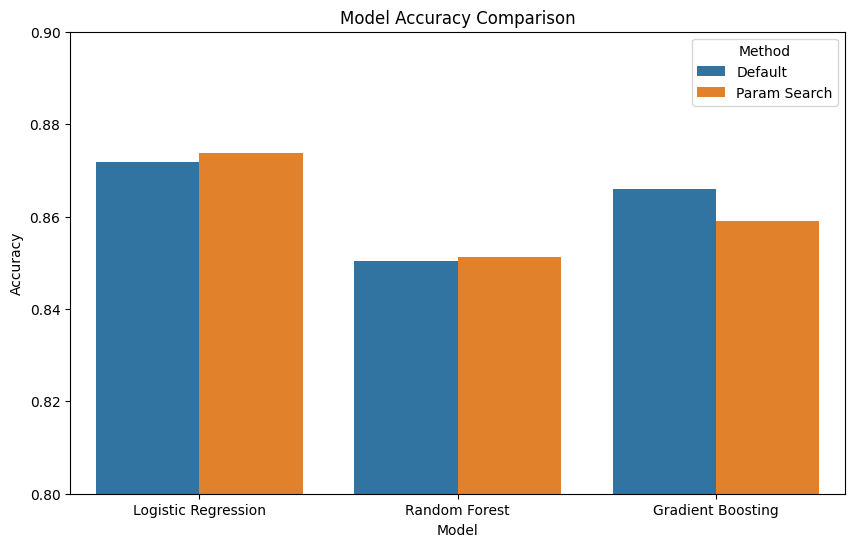

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(data=scores_df, x='Model', y='Accuracy', hue='Method')

plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.8, 0.9)
plt.legend(title='Method')
plt.grid(axis='y')
plt.grid(False)

plt.show()

The overall best model was a parameter-tuned Liblinear Logistic Regression classifier.

What could we do to take this further and improve our results:


*   Scale the data. This might improve overall performance and could allow for other LR solvers to be used.
*   Execute PCA in order to further streamline the feature set.
*   The target variable is not well-balanced. So, it might be wise to apply some resampling or weight classes.
*   Use the variable Age crossed with some other variable (e.g. WorkLifeBalance) to create a new feature to see if that may be useful.





In [23]:
print(scores_df)

                 Model        Method  Accuracy
0  Logistic Regression       Default  0.871712
1  Logistic Regression  Param Search  0.873659
2        Random Forest       Default  0.850348
3        Random Forest  Param Search  0.851319
4    Gradient Boosting       Default  0.865873
5    Gradient Boosting  Param Search  0.859095
